In [39]:

import datetime
import os

import matplotlib.dates as mdates
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

import benford
import pandas


def addStats(df):
    stats = df.describe(include='all')
    stats.loc['var'] = df.var().tolist()
    stats.loc['skew'] = df.skew().tolist()
    stats.loc['kurt'] = df.kurtosis().tolist()
    stats.loc['mad'] = df.mad().tolist()

    return stats

plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100
pandas.set_option('use_inf_as_na', True)

COVID_Raw = pandas.read_csv("./COVID_Raw.csv")
COVID_Raw['Date'] = pandas.to_datetime(COVID_Raw['Date'])
COVID_Raw = COVID_Raw.set_index('Date')
COVID_Raw[['Tested_Cum']] = COVID_Raw[['Tested_Raw']].cumsum()
COVID_Raw[['Tested_Delta']] = COVID_Raw[['Tested_Raw']].pct_change()
COVID_Raw[['Positive_Cum']] = COVID_Raw[['Positive_Raw']].cumsum()
COVID_Raw[['Positive_Delta']] = COVID_Raw[['Positive_Raw']].pct_change()
COVID_Raw[['Recovered_Cum']] = COVID_Raw[['Recovered_Raw']].cumsum()
COVID_Raw[['Recovered_Delta']] = COVID_Raw[['Recovered_Raw']].pct_change()
COVID_Raw[['Died_Cum']] = COVID_Raw[['Died_Raw']].cumsum()
COVID_Raw[['Died_Delta']] = COVID_Raw[['Died_Raw']].pct_change()
COVID_Raw[['Hospitalizations_Cum']] = COVID_Raw[['Hospitalizations_Raw']].cumsum()
COVID_Raw[['Hospitalizations_Delta']] = COVID_Raw[['Hospitalizations_Raw']].pct_change()

COVID_Raw['Tested_Positive_Ratio'] = (COVID_Raw['Positive_Raw'] / COVID_Raw['Tested_Raw']) * 100
COVID_Raw['Active_Infections'] = (COVID_Raw['Positive_Cum'] - (COVID_Raw['Recovered_Cum'] + COVID_Raw['Died_Cum']))

COVID_Raw[['Positive_2D_Mean']] = COVID_Raw[['Positive_Raw']].rolling(2).mean()
COVID_Raw[['Positive_3D_Mean']] = COVID_Raw[['Positive_Raw']].rolling(3).mean()

COVID_Raw = COVID_Raw.fillna(0)

column_order = ['Tested_Raw', 'Tested_Cum', 'Tested_Delta', 'Positive_Raw', 'Positive_Cum', 'Positive_Delta', 'Positive_2D_Mean', 'Positive_3D_Mean', 'Recovered_Raw', 'Recovered_Cum', 'Recovered_Delta', 'Died_Raw', 'Died_Cum', 'Died_Delta', 'Hospitalizations_Raw', 'Hospitalizations_Cum', 'Hospitalizations_Delta', 'Tested_Positive_Ratio', 'Active_Infections']

date = '{:%Y%m%d}'.format(datetime.date.today())
TDays = '14D'
tickFormatter = mdates.DateFormatter('%m-%d')

COVID_for_Pres = COVID_Raw.loc['2020-03-11':'2020-06-21']



 ########## Benford Object Instantiated ########### 

Initial sample size: 1957.

Test performed on 1577 registries.

Number of discarded entries for each test:
{'F1D': 0, 'F2D': 0, 'F3D': 0, 'SD': 0, 'L2D': 0}
L1D not in Benford instance tests - review test's name.

 ###############  First Digit Test  ############### 

Mean Absolute Deviation: 0.014134
0.012000 < MAD <= 0.015000: Marginally Acceptable conformity.

For confidence level 99%: 

	Kolmogorov-Smirnov: 0.040317 
	Critical value: 0.041046 -- PASS

	Chi square: 37.746321 
	Critical value: 20.090000 -- FAIL

	Critical Z-score:2.576.

The entries with the significant positive deviations are:

             Expected     Found   Z_score
First_1_Dig                              
1             0.30103  0.331642  2.622751


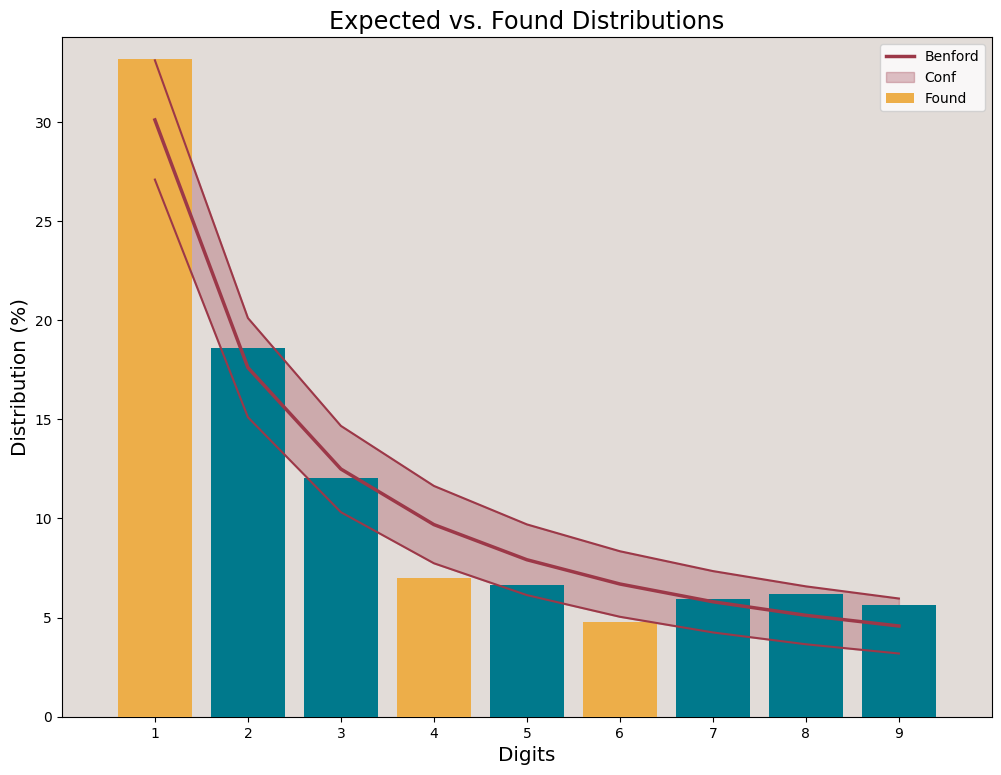

In [40]:
CData_Stack = COVID_for_Pres.stack().reset_index()
ben = benford.Benford(CData_Stack[0], decimals=8)
ben.update_confidence(99, tests=['F1D', 'L1D'])
ben.F1D.report()

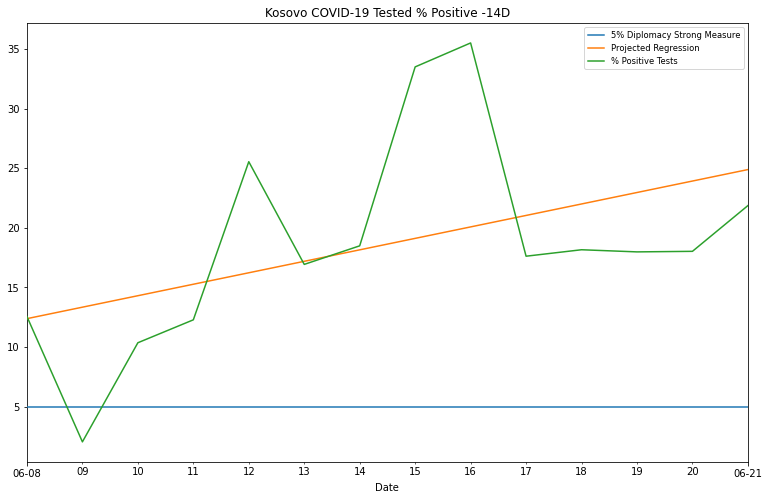

In [46]:
%matplotlib agg
deltaFig = COVID_for_Pres.Tested_Positive_Ratio.plot(title='Kosovo COVID-19 % Positive Tests -L{0} Days'.format(TDays), label='Positive Cases', zorder=10)
Y = COVID_for_Pres.Tested_Positive_Ratio.last(TDays).values.reshape(-1, 1)
X = COVID_for_Pres.last(TDays).index.map(datetime.datetime.toordinal).values.reshape(-1, 1)
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(X, Y)  # perform linear regression
Y_pred = linear_regressor.predict(X)  # make predictions
CPDelta_df = COVID_for_Pres[['Tested_Positive_Ratio']].last(TDays)
CPDelta_df.insert(0, 'LinReg', Y_pred, True)
CPDelta_df.insert(0, '5%_Dip_Strong', 5, True)
%matplotlib inline
deltaFig = CPDelta_df.plot(title='Kosovo COVID-19 Tested % Positive -{0}'.format(TDays), zorder=10)
deltaFig.xaxis.set_major_formatter(tickFormatter)
deltaFig.legend(['5% Diplomacy Strong Measure', 'Projected Regression', '% Positive Tests'], fontsize='small')
deltaFig.figure.tight_layout()
deltaFig.figure.set_size_inches(11.5, 8)

<ipython-input-50-f5831f3487cb>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  deltaFig.set_yticklabels(['0', '0', '1', '10', '100', '1000'])


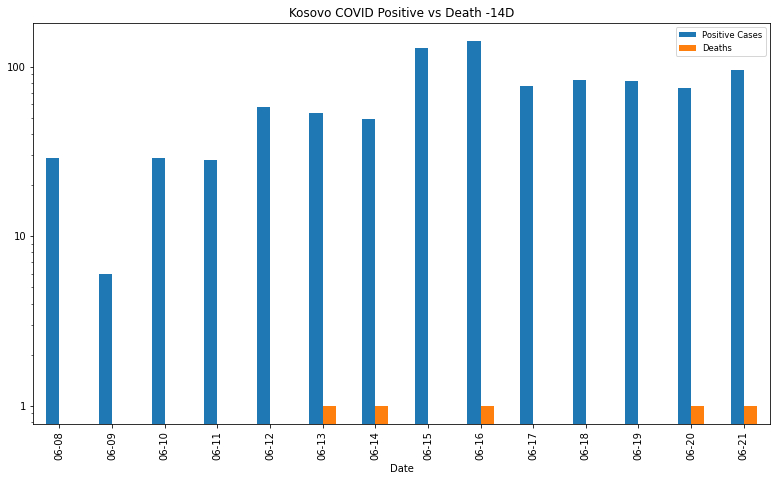

In [50]:
CPDelta_df = COVID_for_Pres[['Positive_Raw', 'Died_Raw']].last(TDays)
ticks = CPDelta_df.index.strftime('%m-%d').values
deltaFig = CPDelta_df.plot(kind='bar', title='Kosovo COVID Positive vs Death -{0}'.format(TDays), logy=True)
deltaFig.legend(['Positive Cases', 'Deaths'], fontsize='small')
deltaFig.set_xticklabels(ticks)
deltaFig.set_yticklabels(['0', '0', '1', '10', '100', '1000'])
deltaFig.figure.tight_layout()
deltaFig.figure.set_size_inches(11.5, 8)

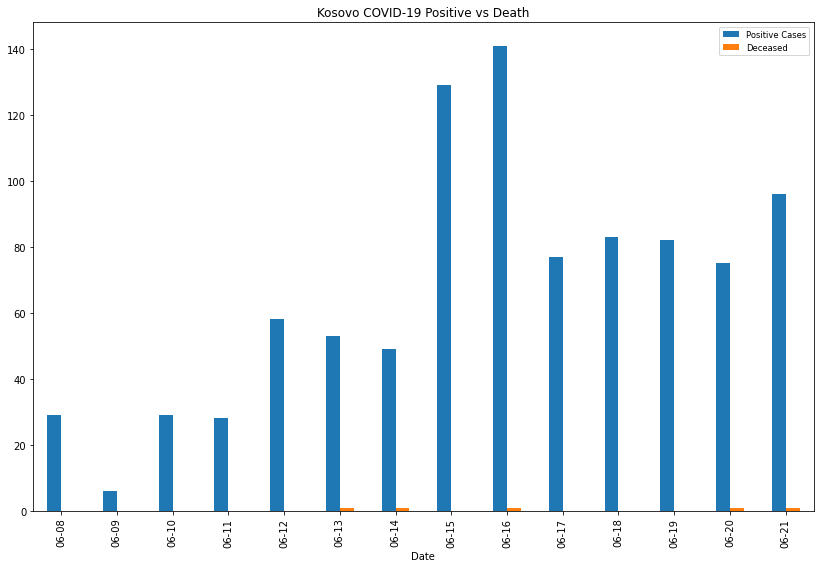

In [66]:
CPDelta_df = COVID_for_Pres[['Positive_Raw', 'Died_Raw']].last(TDays)
deltaFig = CPDelta_df.plot.bar(title='Kosovo COVID-19 Positive vs Death')
deltaFig.figure.set_size_inches(11.5, 8)
ticks = CPDelta_df.index.strftime('%m-%d').values
deltaFig.set_xticklabels(ticks)
deltaFig.legend(['Positive Cases', 'Deceased'], fontsize='small')
deltaFig.figure.tight_layout()